# 0- Introduction

This is the final project of Master in Data Science at Kschool, the name of this project is "Content-based Recommender" and the author is José Mario Fernández González.

The project is a film recommender which is based on a different way of recommendation than most of the recommenders give to the user. Recommenders usually are based in colaborative filtering, as the name suggests, is a filtering based in scores which every user gives to the film, however content-based filtering is designed to extract information about content of the film (genre, actors, overview...), process the content and make it able to compare to each film in the dataset.

The method to get this recommendation is based in cosine similarity, so we treat each film like a vector and we can find the most similar based on getting each cosine with each film, and get the highest similarities. So we need a matrix that contains information about content, so we decided that a TF-IDF matrix could achieve the goal. In short, we need tu build a matrix with information in each row about a film and compare them with cosine.

This means that we only need content information and not biased information like scores or opinions, nevertheless we need a record of the films watched by the user to recommend something.

This notebook and the data used in this notebook is avaliable at

In terms of software required to this program it is required to have a a high performance machine. Most of the code can be computed in a personal computer, but some lines need to have a top performance machine or instead of that, it was computed in a machine provided by IBM compatible with python 3.7 and performance of 6 vCPU and 64 Gb of RAM. So it can be considered as the minimum requirements to run all the code 


Note: Lines marked as "#### High performance #####" probably require a high performance machine.

# Import

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import re
import nltk
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /home/wsuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/wsuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/wsuser/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# 1- Data

## 1.1- Read the data

First of all the data is from "movies_final.csv" which is included in the project and its from

https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system/data

The data was previously preprocessed from the dataset "movies_medata.csv" wich has a dictionary type variables, so it was previously adapted to a tipical dataset wich makes easier to preprocess.

In [2]:
df = pd.read_csv('movies_final.csv')
df.shape

(46628, 20)

In [3]:
df.sample(10)

,Unnamed: 0,adult,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,title,vote_average,vote_count,keywords,actor_1_name,actor_2_name,actor_3_name,director_name
33479,33479,False,comedy family music tv movie,115626,en,stuck in the suburbs,brittany aarons is one of the many girls who ...,6.508145,,,2004-07-16,76.0,stuck in the suburbs,5.2,40.0,pop star teen movie teenager cell phone,Danielle Panabaker,Brenda Song,Ryan Belleville,Savage Steve Holland
30740,30740,False,crime drama,84450,en,buster and billie,dimwitted but sweet high school girl of easy v...,0.139507,black creek billie,united states of america,1974-08-21,100.0,buster e billie,5.0,2.0,rape,Jan-Michael Vincent,Joan Goodfellow,Pamela Sue Martin,Sidney Sheldon Daniel Petrie
35725,35725,False,documentary,320587,en,a brave heart: the lizzie velasquez story,a documentary following the inspiring journey ...,0.161354,,"mexico , united states of america , spain",2015-03-14,90.0,a brave heart: the lizzie velasquez story,8.3,4.0,biography woman director,Lizzie Velasquez,NaN,NaN,Sara Bordo
26098,26098,False,comedy drama,11752,de,freche mädchen,three teen aged girlfriends navigate multiple ...,1.231199,constantin film collina filmproduktion,germany,2008-07-17,97.0,cheeky girls,5.5,8.0,learning and teaching teacher teenage crush wo...,Emilia Schüle,Selina Shirin Müller,Henriette Nagel,Ute Wieland
33568,33568,False,NaN,62091,en,city across the river,brooklyn youth frank cusack good son and brot...,0.042484,,,1949-04-07,91.0,city across the river,5.0,1.0,NaN,Stephen McNally,Thelma Ritter,Luis van Rooten,Maxwell Shane
10849,10849,False,drama romance,12116,fr,l'amour l'après-midi,the last of rohmer s six moral tales frederic...,1.474925,les films du losange,france,1972-08-21,97.0,love in the afternoon,7.6,24.0,man between two women nouvelle vague,Bernard Verley,Françoise Verley,Zouzou,Éric Rohmer
6190,6190,False,action adventure drama family,18992,en,my friend flicka,ken mclaughlin (roddy mcdowall) is a precociou...,0.709930,twentieth century fox film corporation,united states of america,1943-05-26,89.0,my friend flicka,3.8,2.0,horse ranch colt horse ranch,Roddy McDowall,Preston Foster,Rita Johnson,Harold D. Schuster
5677,5677,False,drama romance,35685,en,lady chatterley's lover,a film adaptation of d h lawrence s novel af...,8.637148,london cannon films cine artist film gmbh...,"france , germany , united kingdom",1981-06-29,104.0,lady chatterley's lover,5.4,16.0,male nudity female nudity nurse sex adultery b...,Sylvia Kristel,Shane Briant,Nicholas Clay,Just Jaeckin
21792,21792,False,comedy,180810,en,and now a word from our sponsor,adan kundle ceo of a major advertising agency...,1.393660,,canada,2013-05-10,87.0,and now a word from our sponsor,4.6,14.0,NaN,Bruce Greenwood,Parker Posey,Callum Blue,Zack Bernbaum
45057,45057,False,drama music romance,86231,en,the in crowd,a young man of the rock and roll generation is...,0.755195,force 10 productions,united states of america,1988-02-01,95.0,the in crowd,5.3,5.0,NaN,Donovan Leitch,Joe Pantoliano,Jennifer Runyon,Mark Rosenthal


## 1.2 Preprocess the data

Next step will be preprocess the data to make it avaliable to make data avalaible to make the recommender and visualization. First of all we will drop unnecessary columns so we will make a recap of names and we will make the decision:

In [4]:
df.columns.values

array(['Unnamed: 0', 'adult', 'genres', 'id', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'title',
       'vote_average', 'vote_count', 'keywords', 'actor_1_name',
       'actor_2_name', 'actor_3_name', 'director_name'], dtype=object)

So as we see the only columns we need is: "adult", "genres", "original_title"(or title), "overview", "release_date", "keywords", "actor_1_name", "actor_2_name", "actor_3_name", "director_name", all this column has information about content, so we will take them and wipe out the others

In [5]:
df2 = df.drop(['Unnamed: 0','id','original_language', 'popularity', 'production_companies', 'production_countries', 'runtime',
              'title', 'vote_average','vote_count'], axis = 1)

Next step is to drop duplicate films, if we have duplicates we can recommend same film the user has in the feed because the recommender will give a high similarity about them.

In [6]:
df2 = df2.drop_duplicates(subset=['original_title'])

In [7]:
df2.shape

(43327, 10)

In [8]:
df.shape # There are more than 3000 films duplicated

(46628, 20)

Next step is to drop films which contains names in non-latin characters (we found them in some recommendations).

In [9]:
df3 = df2[~df2['original_title'].str.match(r'.*[^\x00-\xFF]')]

In [10]:
df3.shape # That was near to 4000 films removed

(39594, 10)

In [11]:
df3.sample(10)

,adult,genres,original_title,overview,release_date,keywords,actor_1_name,actor_2_name,actor_3_name,director_name
32672,False,thriller romance,blindside,harvey keitel plays penfield gruber a once gr...,1987-09-01,hotel murder independent film espionage scient...,Harvey Keitel,Lori Hallier,Lolita Davidovich,Paul Lynch
15443,False,horror thriller,ligeia,successful writer and scholar jonathan merrick...,2009-11-05,NaN,Wes Bentley,Kaitlin Doubleday,Sofya Skya,Michael Staininger
13624,False,adventure action comedy science fiction music,dr. horrible's sing-along blog,dr horrible an aspiring supervillain with hi...,2008-07-15,anti hero musical parody mad scientist supervi...,Neil Patrick Harris,Nathan Fillion,Felicia Day,Joss Whedon
12577,False,drama,downhill racer,an ambitious young skier determined to break ...,1969-11-06,sport teammate narcissism injury skiing,Sylvester Stallone,Robert Redford,Gene Hackman,Michael Ritchie
17866,False,drama thriller crime,tight spot,a former model serving time in prison become...,1955-03-19,witness trial district attorney,Ginger Rogers,Edward G. Robinson,Brian Keith,Phil Karlson
12648,False,comedy romance drama,forgetting sarah marshall,when sarah marshall dumps aspiring musician pe...,2008-04-17,hawaii one-night stand beauty,Jason Segel,Kristen Bell,Mila Kunis,Nicholas Stoller
16472,False,comedy drama,barney's version,the picaresque and touching story of the polit...,2010-10-26,suicide jealousy canada independent film polit...,Paul Giamatti,Dustin Hoffman,Rosamund Pike,Richard J. Lewis
17336,False,documentary,stonewall uprising,stonewall uprising is a 2010 american document...,2010-06-16,gay based on novel lgbt history stonewall riot,Paul Bosche,Alfredo del Rio,John DiGiacomo,Kate Davis David Heilbroner
17714,False,drama,tender is the night,director henry king s 1962 film adaptation of ...,1962-01-19,NaN,Jennifer Jones,Jason Robards,Joan Fontaine,Henry King
12033,False,fantasy comedy family,evan almighty,god contacts congressman evan baxter and tells...,2007-06-09,father son relationship daily life married cou...,Steve Carell,Lauren Graham,John Goodman,Tom Shadyac


We can see that there are some "Nan" in the dataset:

In [12]:
df3.isnull().sum()

adult                 0
genres             2163
original_title        0
overview              0
release_date         79
keywords          12098
actor_1_name       2240
actor_2_name       3493
actor_3_name       4292
director_name       818
dtype: int64

Keywords has too many "Nan" so it's better to remove this column to get a better results on recommender.

In [13]:
df4 = df3.drop(['keywords'], axis = 1)

And now we will replace "Nan" with another value and in next steps we will make a list of every content value and we will remove them:

In [14]:
df4['overview'].replace(to_replace='no hay descripcion', value= 'Nada', inplace=True)
df4['genres'].replace(to_replace=np.nan, value= 'Nada', inplace=True)
df4['actor_1_name'].replace(to_replace=np.nan, value= 'Nada', inplace=True)
df4['actor_2_name'].replace(to_replace=np.nan, value= 'Nada', inplace=True)
df4['actor_3_name'].replace(to_replace=np.nan, value= 'Nada', inplace=True)
df4['director_name'].replace(to_replace=np.nan, value= 'Nada', inplace=True)

In [15]:
df4.isnull().sum() # Don't mind about date, it will removed later

adult              0
genres             0
original_title     0
overview           0
release_date      79
actor_1_name       0
actor_2_name       0
actor_3_name       0
director_name      0
dtype: int64

## 1.3 Tokenize Data

In this step we will transform the data to a list of values in each row to process them and get the TF-IDF matrix, next we will define some functions to clear each column.

In [16]:
def overview_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text


def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = text.split(" ")
    return text

def names(text):
    """
    Function to join first names with last names, in actor and director we have
    'James Cameron' if don't join in the list it will be 'James' 'Cameron'
    """
    text = re.sub(" ", "", text)
    return text

stop_words = stopwords.words('english')

def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = SnowballStemmer('english')

#probar snowball

def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_overview(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(overview_clean(text)))

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return initial_clean(names(text))

And now we are able to tokenize each content column

In [17]:
df4['genres'] = df4['genres'].apply(initial_clean) 
df4['cast'] = df4['actor_1_name'].apply(apply_all) + df4['actor_2_name'].apply(apply_all) + df4['actor_3_name'].apply(apply_all)
df4['director_name'] = df4['director_name'].apply(apply_all)
df4['overview'] = df4['overview'].apply(apply_overview)

In [19]:
df5 = df4.drop(['actor_1_name', 'actor_2_name', 'actor_3_name'], axis=1)
df5.sample(10)

,adult,genres,original_title,overview,release_date,director_name,cast
13494,False,"[action, western]",the big stampede,"[deputi, sheriff, john, steel, recruit, bandit...",1932-10-08,[TennyWright],"[JohnWayne, NoahBeery, PaulHurst]"
21997,False,[documentary],stealing a nation,"[tell, stori, liter, hidden, histori, british,...",2004-01-01,[JohnPilgerSeanCrotty],"[JohnPilger, Nada, Nada]"
29621,False,"[science, fiction, action, fantasy]",survivor,"[search, habit, planet, last, live, human, cra...",2014-07-22,[JohnLyde],"[DanielleRyanChuchran, KevinSorbo, RockyMyers]"
42915,False,[drama],7 años,"[drama, center, around, four, friend, busi, pa...",2016-10-28,[RogerGual],"[PacoLeón, JuanPabloRaba, ÀlexBrendemühl]"
6117,False,"[drama, history, war]",gods and generals,"[film, center, most, around, person, professio...",2003-02-21,[RonaldF.Maxwell],"[StephenLang, JeffDaniels, RobertDuvall]"
35272,False,"[music, drama, crime, comedy]",chi-raq,"[modern, day, adapt, ancient, greek, play, lys...",2015-12-04,[SpikeLee],"[TeyonahParris, NickCannon, AngelaBassett]"
25557,False,[comedy],bring it on: in it to win it,"[fourth, bring, movi, set, cheerlead, camp, fl...",2007-12-12,[SteveRash],"[AshleyBenson, CassandraScerbo, NoelAreizaga]"
17197,False,[drama],a idade da terra,"[person, vision, contemporari, brazil, evolut,...",1980-11-17,[GlauberRocha],"[AntônioPitanga, TarcísioMeira, JeceValadão]"
29793,False,[documentary],svezia inferno e paradiso,"[edmund, purdom, narrat, pseudo, documentari, ...",1968-09-04,[LuigiScattini],"[EdmundPurdom, Nada, Nada]"
44334,False,"[horror, action, foreign]",yoroi: samurai zombie,"[famili, kidnap, coupl, gun, wander, lost, get...",2008-06-30,[Nada],"[MitsuruFukikoshi, ShintaroMatsubara, AiriNaka..."


And now we can clear the "Nada" from each list

In [20]:
df5['genres'] = df5['genres'].apply(lambda x: [i for i in x if i != 'Nada'])
df5['cast'] = df5['cast'].apply(lambda x: [i for i in x if i != 'Nada'])
df5['director_name'] = df5['director_name'].apply(lambda x: [i for i in x if i != 'Nada'])
df5['overview'] = df5['overview'].apply(lambda x: [i for i in x if i != 'Nada'])

In [21]:
df5.sample(10)

,adult,genres,original_title,overview,release_date,director_name,cast
9706,False,[comedy],racing stripes,"[shatter, illus, hard, repair, especi, good, h...",2005-01-06,[FrederikDuChau],"[FrankieMuniz, MandyMoore, HaydenPanettiere]"
36512,False,[comedy],klassefesten,"[renion, new, danish, comedi, star, troel, lyb...",2011-10-13,[NielsNørløvHansen],"[NicolajKopernikus, AndersW.Berthelsen, Troels..."
33064,False,"[comedy, fantasy, romance, tv, movie]",mrs. miracle,"[overwhelm, widow, seth, webster, search, hous...",2009-12-05,[MichaelScott],"[ErinKarpluk, JamesVanDerBeek, DorisRoberts]"
4794,False,"[drama, foreign]",la ville est tranquille,"[dark, tale, work, class, life, marseill, citi...",2000-08-30,[RobertGuédiguian],"[ArianeAscaride, Jean-PierreDarroussin, Jacque..."
45027,False,"[tv, movie, comedy, drama]",second string,"[american, footbal, coach, chuck, dichter, wor...",2002-12-18,[RobertLieberman],"[JonVoight, GilBellows, TeriPolo]"
41887,False,"[drama, music]",all eyez on me,"[eyez, chronicl, life, legaci, tupac, shakur, ...",2017-06-12,[BennyBoom],"[DemetriusShippJr., DanaiGurira, KatGraham]"
543,False,"[action, thriller]",terminal velocity,"[maverick, skydiv, former, kgb, agent, team, s...",1994-09-23,[DeranSarafian],"[CharlieSheen, NastassjaKinski, JamesGandolfini]"
14154,False,"[action, adventure, drama, western]",winds of the wasteland,"[arriv, telegraph, put, poni, express, rider, ...",1936-07-06,[MackV.Wright],"[JohnWayne, PhyllisCerf, LewKelly]"
12179,False,"[action, adventure, animation]",tekkon kinkurîto,"[mysteri, foreign, entrepreneur, appear, inten...",2006-12-11,[MichaelArias],"[KazunariNinomiya, YusukeIseya, MinTanaka]"
3631,False,"[action, crime]",assault on precinct 13,"[lone, inhabit, abandon, polic, station, attac...",1976-11-05,[JohnCarpenter],"[AustinStoker, DarwinJoston, LaurieZimmer]"


Now we have to remove every row wich has an empty list in each tokenized column:

In [22]:
# Returns a column with the length of each list of genres
df5['number_genres'] = df5['genres'].apply(lambda x: len(x))

In [23]:
lengths = list(df5['number_genres'])

In [24]:
print("length of list:",len(lengths),
      "\naverage document length", np.average(lengths),
      "\nminimum document length", min(lengths),
      "\nmaximum document length", max(lengths))

length of list: 39594 
average document length 2.0647825428095166 
minimum document length 0 
maximum document length 9


as we can see we have films with 0 genres and films with 9 genres!, so the point here is to remove 0 genres films.

In [36]:
# remove rows with 0 genres
df6 = df5.loc[df5['number_genres'] > 0]

In [37]:
df6.shape 

(37431, 8)

In [38]:
df5.shape # Removed more than 2000 movies

(39594, 8)

And now we will do it with director and actors. They have the same information (important name in a film) so we join both columns.

In [39]:
df6['names'] = df6['cast'] + df6['director_name']

In [40]:
df6['number_names'] = df6['names'].apply(lambda x: len(x))

In [42]:
lengths_2 = list(df6['number_names'])

In [43]:
print("length of list:",len(lengths_2),
      "\naverage document length", np.average(lengths_2),
      "\nminimum document length", min(lengths_2),
      "\nmaximum document length", max(lengths_2))

length of list: 37431 
average document length 3.784002564719083 
minimum document length 0 
maximum document length 4


so there are films with 0 names, they will be removed by the way.

In [45]:
df7 = df6.loc[df6['number_names'] > 0]

In [47]:
df7.shape

(37237, 10)

In [48]:
df6.shape #removed less than 200 movies

(37431, 10)

And now we will remove every row with no overview.

In [49]:
df7['number_overview'] = df7['overview'].apply(lambda x: len(x))

In [51]:
lengths_3 = list(df7['number_overview'])

In [52]:
print("length of list:",len(lengths_3),
      "\naverage document length", np.average(lengths_3),
      "\nminimum document length", min(lengths_3),
      "\nmaximum document length", max(lengths_3))

length of list: 37237 
average document length 30.683674839541318 
minimum document length 0 
maximum document length 137


So there is overviews with no content, but we an overview with 5 words is a useless, so we will find a way to remove many overviews with low content

In [53]:
df_x = df7.loc[df7['number_overview'] > 5]

In [54]:
df_x.shape

(36216, 11)

more than 1000 overviews removed, let's try with 10 words at least.

In [56]:
df_y = df7.loc[df7['number_overview'] > 10]

In [57]:
df_y.shape # 4000+ movies removed

(33114, 11)

In [58]:
#remove column of counts
df = df_y.drop(['number_genres', 'number_overview', 'number_names'], axis=1)

This is a good point to get a good overview, because we removed stopwords and useless characters, so this 10 words could have too much  information so we keep this shape.

In [59]:
# Reset index 
df.reset_index(drop=True, inplace=True)

And now we will see the words each row remains, this variables will be usefull in next steps.

In [60]:
lista_genres = list(df['genres'])
Words_genres = [item for sublist in lista_genres for item in sublist]

lista_names = list(df['names'])
Words_names = [item for sublist in lista_names for item in sublist]

lista_overview = list(df['overview'])
Words_overview = [item for sublist in lista_overview for item in sublist]

In [61]:
len(Words_genres)  #sum of genres of all movies

73515

In [62]:
len(Words_names) #sum of names of all movies

126179

In [63]:
len(Words_overview) #sum of length of all movies

1114060

# 2- Building the feutures of TFIDF matrix

In this section we will build tfidf matrix of every feuture that can give information about content, we build separately for 2 reason, first we need to make different transformation and filters for each feature and second its more efficient in terms of computation to have less columns to compute.

## 2.1- Little adjustments to recommendation

### 2.1.1- Adult filter

First of all, we need to adjust some recommendations, because I could find in the process of recommendation that recommendations for 'Toy Story' give me recommendations about terror films about evil toys, so we will try to avoid this issues and filter by adult and non adult films.

In [64]:
df['adult'] = df['adult'].astype(int)

In [65]:
df.groupby('adult').size() 

adult
0    33109
1        5
dtype: int64

This variable is useless to the problem because this is so unbalanced and we can't fix it so we can't use this filter.

In [66]:
df = df.drop(['adult'], axis=1)

In [67]:
df.sample(10)

,genres,original_title,overview,release_date,director_name,cast,names
25790,"[foreign, horror, thriller]",when night falls,"[thriller, set, two, nurs, trap, countri, mans...",2007-06-01,[AlexGalvin],"[TaniaNolan, RosellaHart, KevinKeys]","[TaniaNolan, RosellaHart, KevinKeys, AlexGalvin]"
21529,"[family, animation]",halloween is grinch night,"[sour, sweet, wind, start, blow, whos, retreat...",1977-10-29,[GerardBaldwinBarringtonBunce],"[HansConried, HalSmith, GaryShapiro]","[HansConried, HalSmith, GaryShapiro, GerardBal..."
8781,"[drama, foreign]",la niña santa,"[amalia, adolesc, girl, caught, throe, emerg, ...",2004-05-06,[LucreciaMartel],"[MaríaAlché, MercedesMorán, CarlosBelloso]","[MaríaAlché, MercedesMorán, CarlosBelloso, Luc..."
17416,"[comedy, crime, mystery]",poupoupidou,"[ambigu, suicid, local, beauti, weathergirl, c...",2011-01-12,[GéraldHustache-Mathieu],"[Jean-PaulRouve, SophieQuinton, OlivierRabourdin]","[Jean-PaulRouve, SophieQuinton, OlivierRabourd..."
29700,"[action, romance, thriller]",baaghi,"[baaghi, stori, ronni, rebelli, year, old, del...",2016-04-29,[SabbirKhan],"[TigerShroff, ShraddhaKapoor, SunilGrover]","[TigerShroff, ShraddhaKapoor, SunilGrover, Sab..."
24194,[horror],le laboratoire de l'angoisse,"[research, imp, laboratori, male, one, except,...",1971-01-01,[PatriceLeconte],"[MariannediVettimo, MarcelGotlib, MichelSuch]","[MariannediVettimo, MarcelGotlib, MichelSuch, ..."
33089,"[comedy, drama, romance]",the fortunes and misfortunes of moll flanders,"[filthi, cell, newgat, prison, moll, flander, ...",1996-10-13,[DavidAttwood],"[JamesBowers, AlexKingston, GeoffreyBeevers]","[JamesBowers, AlexKingston, GeoffreyBeevers, D..."
2744,"[comedy, crime, drama]",born to win,"[film, follow, jay, jay, former, hair, dresser...",1971-12-01,[IvanPasser],"[GeorgeSegal, PaulaPrentiss, KarenBlack]","[GeorgeSegal, PaulaPrentiss, KarenBlack, IvanP..."
27883,[documentary],becoming mike nichols,"[intim, portrait, director, produc, improvis, ...",2016-02-22,[DouglasMcGrath],"[MikeNichols, JackO'Brien]","[MikeNichols, JackO'Brien, DouglasMcGrath]"
7024,"[war, thriller, drama]",the counterfeit traitor,"[blacklist, modern, day, ww, swedish, oil, tra...",1962-04-17,[GeorgeSeaton],"[WilliamHolden, LilliPalmer, HughGriffith]","[WilliamHolden, LilliPalmer, HughGriffith, Geo..."


### 2.1.2- Recommendation by Date

The release date is one of the most useful features to recommend a film to someone, the first films was in black and white and there hadn't any sound, there too much difference between this films and one film with billions of revenue, so we will group film in a range of dates. So we need to take the years and extract some information about it.

In [68]:
df['release_date'] =  pd.to_datetime(df['release_date'])

In [69]:
df['year'] = pd.DatetimeIndex(df['release_date']).year

In [70]:
df['year']

0        1995.0
1        1995.0
2        1995.0
3        1995.0
4        1995.0
          ...  
33109    2017.0
33110    1946.0
33111    2000.0
33112    2000.0
33113    1995.0
Name: year, Length: 33114, dtype: float64

In [71]:
size = len(df['year'])

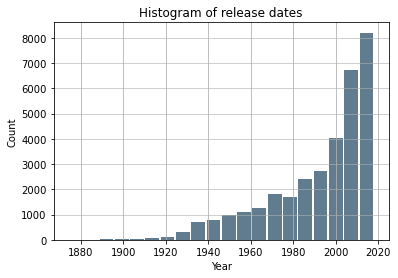

In [72]:
commutes = df['year']

commutes.plot.hist(grid=True, bins=20, rwidth=0.9,color='#607c8e')
plt.title('Histogram of release dates')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

so, we can see that the skeness is crearly negative and it means that most of the films was released in the last 40 years, its so hard to label them, because there are too much genres and styles to get the most truthful separator of intervals. So we can use the quantiles.

In [73]:
df.year.quantile([0.25,0.5,0.75])

0.25    1979.0
0.50    2001.0
0.75    2010.0
Name: year, dtype: float64

It seems that is very good seprator, because films before 1979 are too old to recommend and they are a good recommendation to classic films fans or western fans, between 1979 and 2001 was the first golden age of films and there were too many films about multiple genres and was released the first hundred million revenued films and so on.

The point is that we can get a good separator, however the films that are in the boundary has the problem of they can be separated, that is problem about this separator, but we can find another solution about it so, date recommendation will have less wight than genres or overview.

In [74]:
df['date_label'] = pd.qcut(df['year'], 4, [0,1,2,3])

In [75]:
df.groupby('date_label').size()

date_label
0    8460
1    8370
2    8062
3    8207
dtype: int64

Now we need to convert categories to numbers and give "Nan" values a mean value

In [76]:
df['date_label'] = pd.to_numeric(df['date_label'])

In [77]:
mean_date = df['date_label'].mean()

In [78]:
df['date_label'].replace(to_replace=np.nan, value= mean_date, inplace=True)

## 2.2 Genres & Keywords

In this section we build the tfidf matrix about genres, probably the most important feature of the data because there are too many people who a recommendation about same genre of a film they liked. 

In [79]:
# make a list of every item found in genre column
lista_gk = list(df['genres'])
Words_gk = [item for sublist in lista_gk for item in sublist]

In [80]:
# get a dictionary of pair word-count
fd_gk = FreqDist(list(Words_gk))

In [81]:
len(fd_gk)

22

In [82]:
fd_gk

FreqDist({'drama': 15350, 'comedy': 10403, 'thriller': 5979, 'romance': 5239, 'action': 4908, 'horror': 3709, 'crime': 3266, 'documentary': 3185, 'adventure': 2761, 'science': 2417, ...})

So we have a short number of genres which is really common, but for tfidf method is a problem because we will have a matrix with too much columns (probably 10k+) and 22 columns is not relevant, so we need to reply this columns multiple times to get more weight than others features.

In [83]:
# get names of genres wich give us a list of 22 names
new_gk = fd_gk.items()

uniqueWords_gk = []

for item in new_gk:
   if item not in uniqueWords_gk:
      uniqueWords_gk.append(item[0])

In [84]:
len(uniqueWords_gk)

22

In [85]:
# get the term frequency matrix
cv_1 = CountVectorizer(analyzer = lambda x: x)
cv_1_matrix = cv_1.fit_transform(df['genres']).toarray()
gk_tf = pd.DataFrame(cv_1_matrix,columns=uniqueWords_gk)
gk_tf.shape

(33114, 22)

In [86]:
gk_tf.shape

(33114, 22)

In [87]:
# copy tf matrix to keep shape and get idf matrix from it
gk_idf = gk_tf 

In [88]:
# set all values in matrix to 1 
gk_idf[gk_idf > 1] = 1 

In [89]:
# get inverse document frequency (number of times a word appear in all documents)
gk_inverse = gk_idf.sum(axis=0)

gk_inverse

animation       4908
comedy          2761
family          1312
adventure      10403
fantasy         3266
romance         3185
drama          15350
action          2284
crime           1705
thriller        2417
horror          1141
history         1051
science         3709
fiction          602
mystery         1316
foreign         1931
music           5239
documentary     2417
war             5979
western          602
tv              1058
movie            879
dtype: int64

In [90]:
# get idf matrix 
gk_idf = np.log(gk_idf.shape[0] / gk_inverse)

gk_idf

animation      1.909090
comedy         2.484363
family         3.228403
adventure      1.157862
fantasy        2.316390
romance        2.341504
drama          0.768841
action         2.674028
crime          2.966391
thriller       2.617429
horror         3.368051
history        3.450214
science        2.189194
fiction        4.007454
mystery        3.225359
foreign        2.841918
music          1.843826
documentary    2.617429
war            1.711703
western        4.007454
tv             3.443576
movie          3.628927
dtype: float64

In [91]:
# get tfidf matrix 
gk_tfidf_matrix = gk_tf.mul(gk_idf)
gk_tfidf = pd.DataFrame(gk_tfidf_matrix)

In [92]:
gk_tfidf.head(10) 

,animation,comedy,family,adventure,fantasy,romance,drama,action,crime,thriller,...,science,fiction,mystery,foreign,music,documentary,war,western,tv,movie
0,0.00000,0.000000,3.228403,1.157862,0.00000,0.0,0.000000,2.674028,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.00000,2.484363,0.000000,0.000000,0.00000,0.0,0.000000,2.674028,2.966391,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.00000,0.000000,0.000000,1.157862,0.00000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.843826,0.0,0.000000,0.0,0.0,0.0
3,0.00000,0.000000,0.000000,1.157862,0.00000,0.0,0.768841,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.843826,0.0,0.000000,0.0,0.0,0.0
4,0.00000,0.000000,0.000000,1.157862,0.00000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
5,1.90909,0.000000,0.000000,0.000000,2.31639,0.0,0.768841,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.711703,0.0,0.0,0.0
6,0.00000,0.000000,0.000000,1.157862,0.00000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.843826,0.0,0.000000,0.0,0.0,0.0
7,1.90909,2.484363,0.000000,0.000000,0.00000,0.0,0.768841,2.674028,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
8,1.90909,2.484363,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.711703,0.0,0.0,0.0
9,1.90909,2.484363,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.711703,0.0,0.0,0.0


In [93]:
#Output the shape of tfidf_matrix
gk_tfidf.shape

(33114, 22)

The length of column as we saw previously is too short, so we will need to reply multiple times to get a good length, but we need to get the shape of the other feautures.

# 2.3- Director & Cast

Next feature is important too, because an actor or director can make a person to watch a film, that's why the main cast and director are always at the front page of main page and advertisements, so we will build a tfidf matrix about this feature to add to the recommendation. 

In [94]:
# make a list of every item found in genre column
lista_nam = list(df['names'])
Words_nam = [item for sublist in lista_nam for item in sublist]

In [95]:
# get a dictionary of pair word-count
fd_nam = FreqDist(list(Words_nam))

In [96]:
len(fd_nam)

50335

So this length is so much larger than genres, and its a compute problem to make transformation to a matrix with 54656 columns, so we will reduce to get a good amount of columns, for example, if we need recommendations about this name, we need to find the same values, so if we delete the values that appear less than x times we can reduce the amount of data (for example if 'Pepe Fernandez' appear in 2 films and we set x to 3, 'Pepe Fernandez' will not appear in tfidf matrix).

In [97]:
# erase names wich appear less than 5 times in df_nam
passed_nam = {key:value for key, value in fd_nam.items() if value > 4}

In [98]:
len(passed_nam)

5591

We set the value to more than 4, because we need We set the value to more than 4, because we need a good amount to reduce the computation time and of course we need a big amount of names to not lose the point of this recommendation, there is not a problem about is still much bigger than genres, but we said we will reply columns to get the same or bigger length.

In [99]:
# get names of cast and director wich give us a list of 6291 names
new_names = passed_nam.items()
uniqueWords_nam = []

for item in new_names:
   if item not in uniqueWords_nam:
      uniqueWords_nam.append(item[0])

In [100]:
# Erase names wich was eliminated with the filter 'appear less than 5 times' so we need to make the intersection between
# filtered list and the column 'names'
df['names'] = df['names'].apply(lambda x: list(set(x).intersection(set(uniqueWords_nam))))

In [101]:
# get the term frequency matrix
cv_2 = CountVectorizer(analyzer = lambda x: x)
cv_2_matrix = cv_2.fit_transform(df['names']).toarray()
nam_tf = pd.DataFrame(cv_2_matrix,columns=uniqueWords_nam)
nam_tf.shape

(33114, 5591)

In [102]:
# copy tf matrix to keep shape and get idf matrix from it
nam_idf = nam_tf 

In [103]:
# set all values in matrix to 1 
nam_idf[nam_idf > 1] = 1

In [104]:
# get inverse document frequency (number of times a word appear in all documents)
nam_inverse = nam_idf.sum(axis=0)

nam_inverse

TomHanks             11
TimAllen              6
DonRickles            6
JohnLasseter          5
RobinWilliams        17
                     ..
BernardGorcey         5
LisaLampanelli        3
CatherineBell         4
ClaudiaGalli         12
ChristianI.NybyII     7
Length: 5591, dtype: int64

In [105]:
# get tfidf matrix 
nam_tfidf_matrix = nam_tf.mul(nam_idf)
nam_tfidf = pd.DataFrame(nam_tfidf_matrix)

In [106]:
# get idf matrix 
nam_idf = np.log(nam_idf.shape[0] / nam_inverse)

nam_idf

TomHanks             8.009816
TimAllen             8.615952
DonRickles           8.615952
JohnLasseter         8.798274
RobinWilliams        7.574498
                       ...   
BernardGorcey        8.798274
LisaLampanelli       9.309099
CatherineBell        9.021417
ClaudiaGalli         7.922805
ChristianI.NybyII    8.461801
Length: 5591, dtype: float64

In [107]:
nam_tfidf.head(10) 

,TomHanks,TimAllen,DonRickles,JohnLasseter,RobinWilliams,KirstenDunst,JoeJohnston,WalterMatthau,JackLemmon,Ann-Margret,...,ÖzcanDeniz,ShaneVanDyke,JamesH.White,KevinFair,JimmyCarr,BernardGorcey,LisaLampanelli,CatherineBell,ClaudiaGalli,ChristianI.NybyII
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
#Output the shape of tfidf_matrix
nam_tfidf.shape

(33114, 5591)

And we get the tfidf matrix of the feature names (director and 3 main actors).

# 2.4- Overview

Now the overview will be processed, the problem is it has too many different words inside, this will be a computational problem and it is a must to reduce the amount of words needed in overview TF-IDF matrix.

In [109]:
fd_ow = FreqDist(list(Words_overview))

In [110]:
fdx_ow = FreqDist(dict(fd_ow.most_common()))

Now we will apply a filter to reduce less common words and most common words, less common is to reduce the amount of words, because most of the words don't appear more than 10 times, but we select 15 to reduce the amount of memory needed, and in high boundary we select 5000 as top appearance, because we don't want a words that is too common because it will a redundant information.

In [111]:
passed_ow = {key:value for key, value in fdx_ow.items() if value > 15 and value < 5000}

In [112]:
len(passed_ow)

6998

The final shape is 6998, which is really good to avoid high requirements.

In [113]:
new_overview = passed_ow.items()

In [114]:
uniqueWords_ow = []

for item in new_overview:
   if item not in uniqueWords_ow:
      uniqueWords_ow.append(item[0])

In [115]:
len(uniqueWords_ow)

6998

Now we have to delete values out of the bounds.

In [116]:
df['descripcion'] = df['overview'].apply(lambda x: list(set(x).intersection(set(uniqueWords_ow))))

In [117]:
len(df['descripcion'][112])

27

In [118]:
len(df['overview'][112])

29

In [119]:
a = df['descripcion'][112]
b = df['overview'][112]
list(e for e in b if e not in a) # words excluded with the filter

['hatchet', 'fransisco']

In [120]:
cv_3 = CountVectorizer(analyzer = lambda x: x)
cv_3_matrix = cv_3.fit_transform(df['descripcion']).toarray()
ow_tf = pd.DataFrame(cv_3_matrix,columns=uniqueWords_ow)
ow_tf.shape

(33114, 6998)

In [123]:
ow_tf.head(10)

,young,live,new,love,get,man,two,take,famili,stori,...,vikram,beard,evangel,maxim,drone,fractur,ko,tsunami,tiff,emanuell
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
ow_idf = ow_tf 

In [125]:
ow_idf[ow_idf > 1] = 1

In [126]:
ow_inverse = ow_idf.sum(axis=0)

ow_inverse

young        37
live        420
new          31
love         19
get         141
           ... 
fractur       6
ko           24
tsunami     174
tiff         73
emanuell     36
Length: 6998, dtype: int64

In [127]:
ow_idf = np.log(ow_idf.shape[0] / ow_inverse)

ow_idf

young       6.796794
live        4.367457
new         6.973724
love        7.463272
get         5.458952
              ...   
fractur     8.615952
ko          7.229658
tsunami     5.248656
tiff        6.117252
emanuell    6.824192
Length: 6998, dtype: float64

In [128]:
ow_tfidf_matrix = ow_tf.mul(ow_idf)

In [129]:
ow_tfidf = pd.DataFrame(ow_tfidf_matrix)

In [130]:
ow_tfidf.head(10) 

,young,live,new,love,get,man,two,take,famili,stori,...,vikram,beard,evangel,maxim,drone,fractur,ko,tsunami,tiff,emanuell
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.231562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
#Output the shape of tfidf_matrix
ow_tfidf.shape

(33114, 6998)

And we have 4 TF-IDF matrix, now let's join them in the next section.

# 3- Combine the content

Now we will combine all matrices into a big one, first we need to reduce the amount of columns of overview and names, and then we need to reply more columns of genres and date.

## 3.1- Reduce the data

We need to reduce the columns of 2 big matrices and the method chosen for that is a PCA, this method return a matrix with reduced column which cost a % of information about the data, we need to reduce at least to 2-3k columns and we set the desired lose of information about 20% or less.

In [132]:
my_model_1= PCA(n_components = 5591)
my_model_1.fit_transform(nam_tfidf)

array([[-1.10653921e-02,  1.22685653e-02, -1.72748509e-02, ...,
         3.43715184e-17,  3.38550553e-18, -6.20279072e-19],
       [-1.23298159e-02,  4.19883407e-02, -1.01537847e-02, ...,
        -5.48843670e-17,  1.58060240e-16,  8.39502692e-19],
       [ 7.75616610e-03, -1.68293700e-02, -1.53942117e-02, ...,
         1.43042829e-17, -1.73362601e-17, -8.67502853e-19],
       ...,
       [-3.38379395e-03, -5.10577496e-03, -1.90113602e-03, ...,
         2.28744428e-19,  1.52511710e-18,  2.29287388e-19],
       [-3.38379395e-03, -5.10577496e-03, -1.90113602e-03, ...,
         2.28744428e-19,  1.52511710e-18,  2.29287388e-19],
       [-3.38379395e-03, -5.10577496e-03, -1.90113602e-03, ...,
         2.28744428e-19,  1.52511710e-18,  2.29287388e-19]])

This will give us the PCA transformation and we need the cumulate sum of explained variance ratio to give us information about how many variables we need.

In [133]:
c = my_model_1.explained_variance_ratio_.cumsum()

Now we have to set a random number to get the desired values we set before

In [134]:
c[500] # too low

0.2951625684395956

In [135]:
c[1600] #60% is a bit low

0.6012935016378005

In [136]:
c[2300] #let's try a bigger value

0.7224103501230414

In [137]:
c[2900] # this is a good value

0.8021118417069355

now we have to build a matrix with 2900 columns with 80,21% information of original matrix.

In [138]:
my_model_nam = PCA(n_components = 2900)
pca_nam = my_model_nam.fit_transform(nam_tfidf)

We have to do it again with overview TFIDF matrix.

In [139]:
my_model_2= PCA(n_components = 6998)

In [140]:
my_model_2.fit_transform(ow_tfidf)

array([[ 7.56427963e-02, -1.27023437e-01, -4.79482289e-01, ...,
        -2.88179825e-03,  1.15883541e-02, -3.07492003e-03],
       [-3.08581638e-02,  1.47220135e-02,  9.15380045e-01, ...,
        -1.03045557e-01, -1.66166144e-02, -1.82479172e-02],
       [ 3.84377803e-01, -9.41021580e-01, -9.48568488e-01, ...,
        -2.29927169e-02,  1.87531317e-02,  1.46891574e-03],
       ...,
       [-1.99750188e+00,  4.40462139e-01, -1.87481264e-02, ...,
         1.27751641e-03,  3.29531734e-03, -7.66161146e-04],
       [-1.84052717e+00, -2.98512369e-01, -3.23417443e-01, ...,
         5.62644958e-03,  1.80217003e-02,  4.02262658e-03],
       [ 2.84952480e-01,  2.67551816e-01,  2.93404729e+00, ...,
         4.77409695e-03, -1.02244549e-02, -9.02830344e-03]])

In [141]:
d = my_model_2.explained_variance_ratio_.cumsum()

In [142]:
d[500] # too low

0.29693591767707905

In [143]:
d[1600] # low

0.6010493632499072

In [144]:
d[2400] #try another value

0.7280435857674404

In [145]:
d[3200] # try a lower value

0.8166498452968228

In [146]:
d[3050] # that's a good value and we lose only 1,5 % of information with 150 less columns

0.8021839109049659

In [147]:
my_model_ow = PCA(n_components = 3050)
pca_ow = my_model_ow.fit_transform(ow_tfidf)

And now we need to convert them into a dataframe.

In [148]:
nam_df = pd.DataFrame(data= pca_nam)

In [149]:
nam_df.shape

(33114, 2900)

In [150]:
ow_df = pd.DataFrame(data= pca_ow)

In [151]:
ow_df.shape

(33114, 3050)

## 3.2- Reply the data

Now we have to reply the small matrices to have a good weight for cosine similarity. For genres we have to set a minimum a 2x than names and overview, this means we need to reply more than 200 times, specifically about 290 times.

In [152]:
gk_tfidf = pd.concat([gk_tfidf]*290, axis=1) #### High performance #####

In [153]:
gk_tfidf.shape

(33114, 6380)

We set the date a half than names and overview because the date is important, but we haven't good a 100% reliable seprator, so we give it a lower weight to give them better result and not being so influential.

In [154]:
date_final = pd.concat([df['date_label']]*1500, axis=1) 

In [155]:
date_final.head(10)

,date_label,date_label,date_label,date_label,date_label,date_label,date_label,date_label,date_label,date_label,...,date_label,date_label,date_label,date_label,date_label,date_label,date_label,date_label,date_label,date_label
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [156]:
final_tfidf = pd.concat([gk_tfidf, nam_df,ow_df, date_final], axis=1, join="inner")

In [157]:
final_tfidf.shape

(33114, 13830)

# 4.- Build & Run Recommender

Now we build the final matrix, now the only steps ahead is build cosine similarity matrix and a recommender function which takes recomendation from this matrix.

In [158]:
cosine_sim = cosine_similarity(final_tfidf)   #### High performance #####

In [159]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df.index, index=df['original_title'])

In the next line will be the recommendation function, from a list of movies (they must to be in the dataset) they will give the top 15 movies wich has the highest mean cosine (mean of all cosines in same row) wighted by the top 3 genres of all films. Wich means if a film has 0 top genres its cosines will be 0, 1 all cosines remains, 2 multiplied by 2 and 3 multiplied by 3, with that scores we set the mean of rows and sort descending to get the highest 15 values that are the best 15 recommendation for a feed of 1 user.

In [160]:
def user_recommendations(user, cosine_sim=cosine_sim):
    # Get the index of the product that matches the title
    idx = indices[user]
    lista_id = list(idx)
    
    # Get the genres of each film watched by user
    generos = pd.DataFrame(df.iloc[idx,0])
    
    # Get every word in a list 
    list_gen = list(generos['genres'])
    word_gen = [item for sublist in list_gen for item in sublist]
    
    # Get the dictionary and the top 3 most common genres
    fd = FreqDist(list(word_gen))
    fdx = FreqDist(dict(fd.most_common(3)))
    
    #We get a list with top 3 words
    items = fdx.items()
    uniqueWords = []
    for item in items:
        if item not in uniqueWords:
            uniqueWords.append(item[0])
    
    #Get the times a genre is in a film and get a list of the counter
    generos['count'] = generos['genres'].apply(lambda x: list(set(x).intersection(set(uniqueWords))))
    generos['count'] = generos['count'].apply(lambda x: list(x))
    generos['count'] = generos['count'].apply(lambda x: len(x))
    numbers = list(generos['count'])
    
    # Get the similarity score for each film in user's feed
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    #Build a dataframe with a list of sim_scores of every film in user's feed
    recomendation = pd.DataFrame(columns = user)
    for i in range(len(sim_scores)):
        recomendation[user[i]] = sim_scores[i][1]

    # Get the new sim_scores wighted by the number of top genres each film has (ex. if top 3 is (action, comedy, sci-fi), if feed film has
    # action and comedy, the whole column will be multiply by 2 and so on)
    recomendation.loc[:, user] *= np.array(numbers)
    
    #We get the means of every row to get the mean score and then sort the values in descending order
    recomendation_final= recomendation.mean(axis=1).sort_values(ascending=False)
    
    # Get the product indices
    product_index = recomendation_final.index.tolist()
    
    #remove the source films
    product_index = [e for e in product_index if e not in lista_id]
    
    #Select the 15 most similar films removing after 16th element
    product_index = product_index[0:14]

    # Return the top 15 most similar products
    return df['original_title'].iloc[product_index]

Now let's try with an example user:

In [161]:
usuario_1 = ['i am legend', 'wonder women','waterloo bridge']

In [162]:
recommendation_1 = user_recommendations(usuario_1)
recommendation_1

3293           phantasm ii
3624          deepstar six
7687     dead end drive-in
2214              existenz
18007         full eclipse
4049             def-con 4
1024                aliens
3929              watchers
16997           brain dead
3060            the hidden
5989         death machine
3873             dead heat
2009         godzilla 1985
3924             they live
Name: original_title, dtype: object

Let's see how it performed first we have to see the content

In [163]:
index_feed = indices[usuario_1]

In [164]:
df.iloc[index_feed]

,genres,original_title,overview,release_date,director_name,cast,names,year,date_label,descripcion
10306,"[drama, horror, action, thriller, science, fic...",i am legend,"[robert, nevill, scientist, unabl, stop, sprea...",2007-12-14,[FrancisLawrence],"[WillSmith, AliceBraga, CharlieTahan]","[WillSmith, AliceBraga, FrancisLawrence]",2007.0,2.0,"[last, york, immun, man, spread, survivor, inc..."
30770,"[action, horror, science, fiction, thriller]",wonder women,"[dr, tsu, brilliant, surgeon, exot, island, co...",1973-04-25,[RobertVincentO'Neill],"[NancyKwan, RossHagen, MariaDeAragon]",[NancyKwan],1973.0,0.0,"[insur, exot, transplant, sell, becom, involv,..."
8474,"[drama, romance]",waterloo bridge,"[eve, world, war, ii, british, offic, revisit,...",1940-05-17,[MervynLeRoy],"[VivienLeigh, RobertTaylor, LucileWatson]","[LucileWatson, MervynLeRoy, VivienLeigh, Rober...",1940.0,0.0,"[stay, front, noth, action, fall, hope, famili..."


In [165]:
index_reco = recommendation_1.index

In [166]:
df.iloc[index_reco]

,genres,original_title,overview,release_date,director_name,cast,names,year,date_label,descripcion
3293,"[action, horror, science, fiction, thriller]",phantasm ii,"[mike, releas, psychiatr, hospit, team, old, p...",1988-07-08,[DonCoscarelli],"[JamesLeGros, ReggieBannister, AngusScrimm]","[AngusScrimm, JamesLeGros, DonCoscarelli]",1988.0,1.0,"[hospit, man, becom, mike, reggi, tall, must, ..."
3624,"[action, horror, thriller, science, fiction]",deepstar six,"[crew, experiment, underwat, nuclear, base, fo...",1989-01-13,[SeanS.Cunningham],"[TaureanBlacque, NancyEverhard, GregEvigan]","[SeanS.Cunningham, GregEvigan]",1989.0,1.0,"[underwat, live, creatur, base, experiment, th..."
7687,"[action, drama, horror, science, fiction, thri...",dead end drive-in,"[near, futur, drive, theatr, turn, concentr, c...",1986-08-13,[BrianTrenchard-Smith],"[NedManning, NatalieMcCurry, PeterWhitford]",[BrianTrenchard-Smith],1986.0,1.0,"[carmen, live, better, realli, camp, place, wa..."
2214,"[action, thriller, science, fiction, horror]",existenz,"[game, design, run, assassin, must, play, late...",1999-04-14,[DavidCronenberg],"[JenniferJasonLeigh, JudeLaw, IanHolm]","[DavidCronenberg, IanHolm, JenniferJasonLeigh,...",1999.0,1.0,"[design, assassin, latest, must, determin, dam..."
18007,"[horror, action, thriller, science, fiction]",full eclipse,"[la, polic, depart, special, team, offic, tale...",1993-11-27,[AnthonyHickox],"[MarioVanPeebles, PatsyKensit, BrucePayne]","[MarioVanPeebles, AnthonyHickox, BrucePayne, P...",1993.0,1.0,"[depart, track, special, unconvent, time, crim..."
4049,"[horror, science, fiction, thriller, action]",def-con 4,"[two, men, woman, circl, globe, satellit, arm,...",1985-03-15,[PaulDonovanDigbyCook],"[LenoreZann, MauryChaykin, KateLynch]",[MauryChaykin],1985.0,1.0,"[stay, remain, later, war, man, survivor, kill..."
1024,"[horror, action, thriller, science, fiction]",aliens,"[ripley, lifepod, found, salvag, crew, year, l...",1986-07-18,[JamesCameron],"[SigourneyWeaver, MichaelBiehn, JamesRemar]","[SigourneyWeaver, MichaelBiehn, JamesRemar, Ja...",1986.0,1.0,"[famili, later, stori, investig, send, search,..."
3929,"[action, horror, science, fiction, thriller]",watchers,"[boy, take, stray, dog, later, find, ultra, in...",1988-12-02,[JonHess],"[CoreyHaim, MichaelIronside, LalaSloatman]","[CoreyHaim, MichaelIronside]",1988.0,1.0,"[runaway, later, ultra, intellig, boy, genet, ..."
16997,"[horror, action, thriller, science, fiction]",brain dead,"[psycholog, thriller, writer, origin, twilight...",1990-01-16,[AdamSimon],"[BillPullman, BillPaxton, NicholasPryor]","[BillPaxton, BillPullman]",1990.0,1.0,"[twilight, nightmar, thriller, tri, machin, ma..."
3060,"[action, horror, science, fiction, thriller]",the hidden,"[alien, run, america, get, kick, kill, anyth, ...",1987-10-30,[JackSholder],"[KyleMacLachlan, MichaelNouri, ClaudiaChristian]","[KyleMacLachlan, JackSholder, ClaudiaChristian...",1987.0,1.0,"[way, borrow, place, goal, dead, kill, kick, n..."


As we can see most of the film has the same genre and they are near the mean time of the all 3 released dates, so we can see that there is a good recommendation, but we can't check if it's robust, because user has to watch all the films to give an opinion of how good is our recommendation.